# Preparation stuff

In [2]:
#Put all imports here
import numpy as np
import matplotlib.pyplot as plt
#from copy import deepcopy
#import pickle
import os
import sys
#import cv2
import torch

In [3]:
#every path should start from the project folder:
project_folder = "../"

#Config folder should contain hyperparameters configurations
cfg_folder = os.path.join(project_folder,"cfg")

#Data folder should contain raw and preprocessed data
data_folder = os.path.join(project_folder,"data")
raw_data_folder = os.path.join(data_folder,"raw")
processed_data_folder = os.path.join(data_folder,"processed")

#Source folder should contain all the (essential) source code
source_folder = os.path.join(project_folder,"src")

#The out folder should contain all outputs: models, results, plots, etc.
out_folder = os.path.join(project_folder,"out")
img_folder = os.path.join(out_folder,"img")

In [4]:
#To import from src:

#attach the source folder to the start of sys.path
sys.path.insert(0, project_folder)

#import from src directory
# from src import ??? as additional_module
import easy_rec as additional_module #REMOVE THIS LINE IF IMPORTING OWN ADDITIONAL MODULE

import easy_exp, easy_rec, easy_torch #easy_data

# MAIN

## Train

### Data

In [5]:
cfg = easy_exp.cfg.load_configuration("config_rec")

In [6]:
cfg["data_params"]["data_folder"] = raw_data_folder

In [7]:
def compute_seq_len(data):
    seq_len = 0
    all_values = {}
    while True:
        seq_len += 1
        print("seq_len",seq_len)
        # Divide each sequence into a (sequence of length seq_len, next_item)

        all_seqs = []
        for seq in data["train_sid"]:
            for i in range(len(seq)-seq_len):
                all_seqs.append((seq[i:i+seq_len],seq[i+seq_len]))

        # Find how many same sequences have different next items

        seq_dict = {}
        for seq, next_item in all_seqs:
            seq = tuple(seq)
            if seq in seq_dict:
                seq_dict[seq] += 1
            else:
                seq_dict[seq] = 1
        app = np.array(list(seq_dict.values()))
        app = app[app>1]
        value = np.sum(app)
        all_values[seq_len] = value
        if value == 0:
            break
    return all_values

In [8]:
#cfg["data_params"]["test_sizes"] = [cfg["data_params.dataset_params.out_seq_len.val"],cfg["data_params.dataset_params.out_seq_len.test"]]
all_values = {}
for _ in cfg.sweep("data_params.name"):
    print(cfg["data_params.name"])
    data, maps = easy_rec.data_generation_utils.preprocess_dataset(**cfg["data_params"])

    all_values[cfg['data_params.name']] = compute_seq_len(data)

amazon_beauty
Ratings data already exists. Skip pre-processing
Filtering by minimum number of users per item: 5
Filtering by minimum number of items per user: 5
Densifying index
Splitting: leave_n_out
seq_len 1
seq_len 2
seq_len 3
seq_len 4
seq_len 5
seq_len 6
seq_len 7
seq_len 8
seq_len 9
ml-1m
Ratings data already exists. Skip pre-processing
Filtering by minimum number of users per item: 5
Filtering by minimum number of items per user: 5
Densifying index
Splitting: leave_n_out
seq_len 1
seq_len 2
seq_len 3
seq_len 4
seq_len 5
seq_len 6
seq_len 7
seq_len 8
foursquare-nyc
Ratings data already exists. Skip pre-processing
Filtering by minimum number of users per item: 5
Filtering by minimum number of items per user: 5
Densifying index
Splitting: leave_n_out
seq_len 1
seq_len 2
seq_len 3
seq_len 4
seq_len 5
seq_len 6
seq_len 7
seq_len 8
seq_len 9
seq_len 10
seq_len 11
seq_len 12
seq_len 13
seq_len 14
seq_len 15
seq_len 16
seq_len 17
seq_len 18
seq_len 19
seq_len 20
seq_len 21
seq_len 22
s

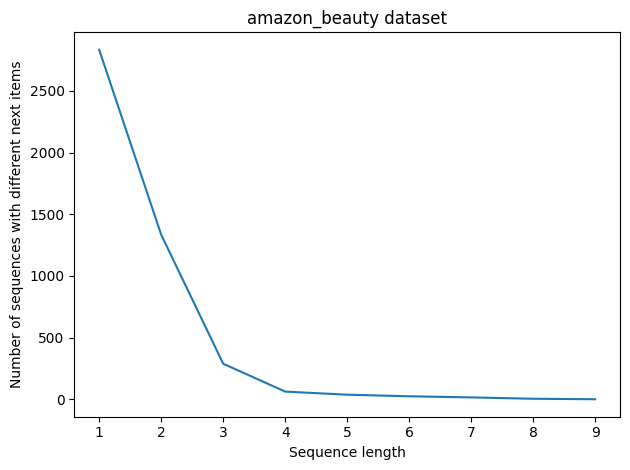

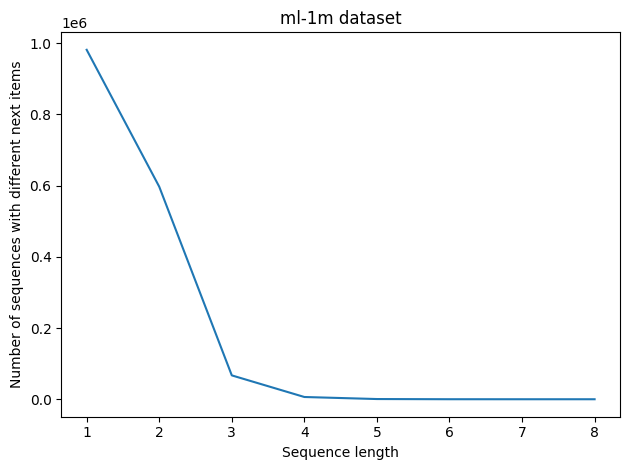

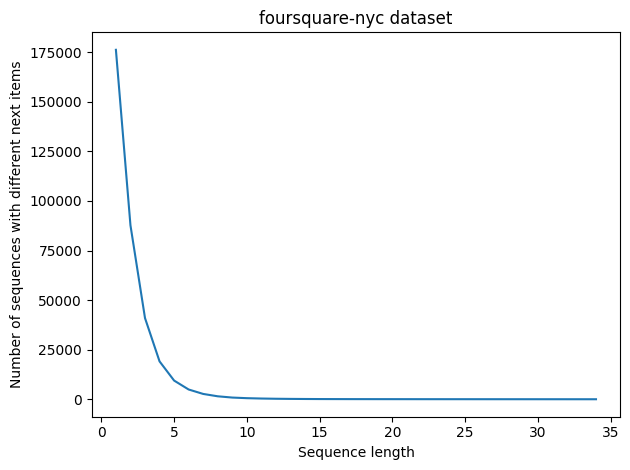

In [11]:
# Plot the results
for _ in cfg.sweep("data_params.name"):
    values = all_values[cfg['data_params.name']]

    plt.plot(list(values.keys()),list(values.values()))
    plt.xlabel("Sequence length")
    plt.ylabel("Number of sequences with different next items")
    plt.title(f"{cfg['data_params.name']} dataset")
    plt.tight_layout()
    plt.savefig(os.path.join(img_folder,f"seq_len_{cfg['data_params.name']}.pdf"), bbox_inches='tight',pad_inches = 0,)
    plt.show()

In [10]:
datasets = easy_rec.rec_torch.prepare_rec_datasets(data,**cfg["data_params"]["dataset_params"])

In [11]:
cfg["data_params"]["collator_params"]["num_items"] = np.max(list(maps["sid"].values()))

In [ ]:
collators = easy_rec.rec_torch.prepare_rec_collators(data, **cfg["data_params"]["collator_params"])

In [12]:
loaders = easy_rec.rec_torch.prepare_rec_data_loaders(datasets, **cfg["model"]["loader_params"], collate_fn=collators)

In [16]:
#for x in loaders["train"]: break

In [15]:
cfg["model"]["rec_model"]["num_items"] = np.max(list(maps["sid"].values()))
cfg["model"]["rec_model"]["num_users"] = np.max(list(maps["uid"].values()))
cfg["model"]["rec_model"]["lookback"] = cfg["data_params"]["collator_params"]["lookback"]

In [16]:
main_module = easy_rec.rec_torch.create_rec_model(**cfg["model"]["rec_model"])

Seed set to 42


In [17]:
exp_found, experiment_id = easy_exp.exp.get_set_experiment_id(cfg)
print("Experiment already found:", exp_found, "----> The experiment id is:", experiment_id)

../out/exp not found --> creating
../out/exp/prova not found --> creating
Experiment already found: False ----> The experiment id is: i7wWDu0p6cpVK3vJ


In [17]:
#if exp_found: exit() #TODO: make the notebook/script stop here if the experiment is already found

In [18]:
trainer_params = easy_torch.preparation.prepare_experiment_id(cfg["model"]["trainer_params"], experiment_id)

# Prepare callbacks and logger using the prepared trainer_params
trainer_params["callbacks"] = easy_torch.preparation.prepare_callbacks(trainer_params)
trainer_params["logger"] = easy_torch.preparation.prepare_logger(trainer_params)

# Prepare the trainer using the prepared trainer_params
trainer = easy_torch.preparation.prepare_trainer(**trainer_params)

model_params = cfg["model"].copy()

model_params["loss"] = easy_torch.preparation.prepare_loss(cfg["model"]["loss"], additional_module)

# Prepare the optimizer using configuration from cfg
model_params["optimizer"] = easy_torch.preparation.prepare_optimizer(**cfg["model"]["optimizer"])

# Prepare the metrics using configuration from cfg
model_params["metrics"] = easy_torch.preparation.prepare_metrics(cfg["model"]["metrics"], additional_module)

# Create the model using main_module, loss, and optimizer
model = easy_torch.process.create_model(main_module, **model_params)

Seed set to 42
Seed set to 42
Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Seed set to 42
Seed set to 42
Seed set to 42
Seed set to 42


In [19]:
# Prepare the emission tracker using configuration from cfg
tracker = easy_torch.preparation.prepare_emission_tracker(**cfg["model"]["emission_tracker"], experiment_id=experiment_id)

### Train

In [20]:
# Train the model using the prepared trainer, model, and data loaders
easy_torch.process.train_model(trainer, model, loaders, tracker=tracker, val_key=["val","test"])

Seed set to 42
Missing logger folder: ../out/log/prova/i7wWDu0p6cpVK3vJ/lightning_logs

  | Name        | Type                        | Params
------------------------------------------------------------
0 | main_module | SASRec                      | 242 K 
1 | loss        | SequentialBCEWithLogitsLoss | 0     
2 | metrics     | ModuleDict                  | 0     
------------------------------------------------------------
242 K     Trainable params
0         Non-trainable params
242 K     Total params
0.969     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
/opt/homebrew/lib/python3.11/site-packages/codecarbon/output.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])


In [21]:
easy_torch.process.test_model(trainer, model, loaders, tracker=tracker)

Seed set to 42


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_F1_@10          0.1803482621908188
       test_F1_@20          0.0945984423160553
       test_F1_@5           0.3304227888584137
      test_MAP_@10         0.013902423903346062
      test_MAP_@20         0.014085136353969574
       test_MAP_@5         0.013746137730777264
      test_MRR_@10          0.0407758429646492
      test_MRR_@20         0.050386205315589905
       test_MRR_@5          0.0316363088786602
      test_NDCG_@10         0.06401288509368896
      test_NDCG_@20         0.09997379779815674
      test_NDCG_@5          0.04126125946640968
   test_Precision_@10      0.014271524734795094
   test_Precision_@20      0.014346025884151459
    test_Precision_@5      0.014205297455191612

In [22]:
# Save experiment and print the current configuration
#save_experiment_and_print_config(cfg)
easy_exp.exp.save_experiment(cfg)

# Print completion message
print("Execution completed.")
print("######################################################################")
print()

Execution completed.
######################################################################

